In [167]:
import torch
import requests
import os
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
device = "cuda"
image_path = Path("more_images/")
train_dir = Path("more_images/train/")
test_dir = Path("more_images/test/")
if image_path.is_dir():
    print(f"{image_path} directory exists.")
train_dir, test_dir
image_path_list = list(image_path.glob("*/*/*.jpeg"))

more_images directory exists.


In [168]:
#utility functions all 
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2, figsize = (5,5))
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
  return train_dataloader, test_dataloader, class_names
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    model.to(device)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results



In [169]:
manual_transforms = transforms.Compose([
    transforms.Resize((80, 80), antialias=True),
    # transforms.RandomResizedCrop((80, 80), scale=(0.9, 1.0)),
    transforms.CenterCrop(70),
    # transforms.Resize((244, 244), antialias=True),
    # transforms.RandomHorizontalFlip(), 
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    # transforms.RandomAffine(degrees=40, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

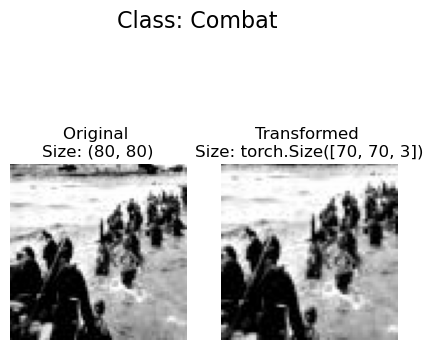

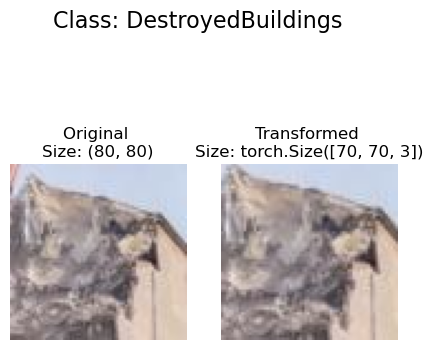

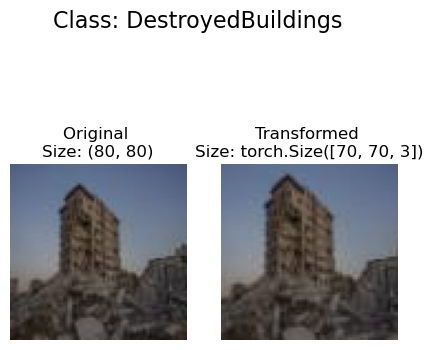

In [170]:
plot_transformed_images(image_path_list, 
                        transform=manual_transforms, 
                        n=3)

In [171]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
auto_transforms = weights.transforms()
for param in model.features.parameters():
    param.requires_grad = False

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [172]:
#0: auto
#1: manual
k = 1
if k == 0:
    train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

    train_dataloader, test_dataloader, class_names

if k==1:
    train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

    train_dataloader, test_dataloader, class_names


In [173]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=128, # same number of output units as our number of classes
                    bias=True),
    nn.ReLU(),
    torch.nn.Linear(in_features=128, 
                    out_features=5, # same number of output units as our number of classes
                    bias=True),
    # nn.ReLU(),
    # torch.nn.Linear(in_features=128, 
    #                 out_features=output_shape, # same number of output units as our number of classes
    #                 bias=True)
    
    ).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

In [174]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2812 | train_acc: 0.9220 | test_loss: 0.1286 | test_acc: 0.9629
Epoch: 2 | train_loss: 0.1576 | train_acc: 0.9653 | test_loss: 0.0396 | test_acc: 0.9824
Epoch: 3 | train_loss: 0.1566 | train_acc: 0.9721 | test_loss: 0.0897 | test_acc: 0.9805
Epoch: 4 | train_loss: 0.1381 | train_acc: 0.9760 | test_loss: 0.0253 | test_acc: 0.9922
Epoch: 5 | train_loss: 0.1365 | train_acc: 0.9791 | test_loss: 0.0292 | test_acc: 0.9902
[INFO] Total training time: 103.149 seconds


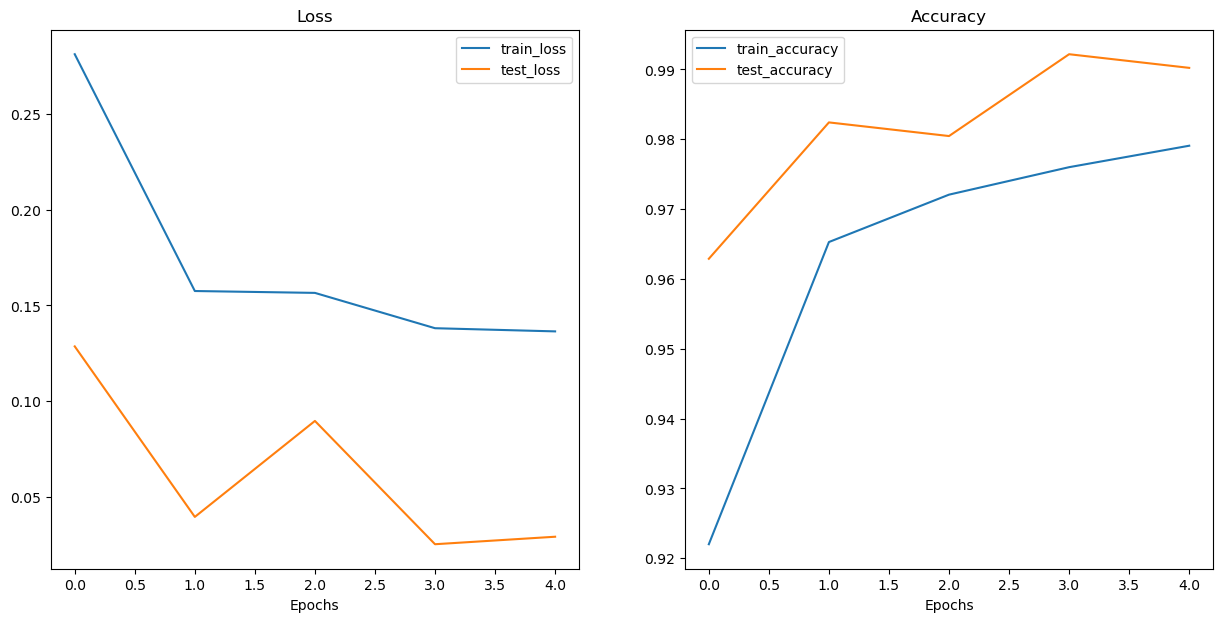

In [175]:
plot_loss_curves(results)

In [203]:
# test_image_path = "/home/adi/Downloads/cropped1.png"
manual_transforms2 = transforms.Compose([
    transforms.Resize((80, 80), antialias=True),
    # transforms.RandomResizedCrop((80, 80), scale=(0.8, 1.0)),
    transforms.CenterCrop(70),
    # transforms.Resize((244, 244), antialias=True),
    # transforms.RandomHorizontalFlip(), 
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    # transforms.RandomAffine(degrees=40, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
for i in range(1,6):
    test_image_path = f"nim{i}.jpg"

    test_image = Image.open(test_image_path)
    # print(type(test_image))

    # test_image = manual_transforms(test_image)
    test_image = manual_transforms2(test_image)


    model.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(test_image.unsqueeze(0).to(device))  # Use unsqueeze(0) to add a batch dimension

    target_image_pred = output
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    print(class_names[target_image_pred_label.item()])

DestroyedBuildings
Fire
Combat
Military vehicles and weapons
Combat


In [191]:
for i in class_names:
    folder_path = f"images/train/{i}"
    file_list = os.listdir(folder_path)
    positive = 0
    negative = 0
    for file_name in file_list:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(folder_path, file_name)
            img = Image.open(image_path)
            test_image = manual_transforms(img)
            model.to(device)
            model.eval()
            with torch.no_grad():
                output = model(test_image.unsqueeze(0).to(device))
            target_image_pred = output
            target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
            target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
            if(class_names[target_image_pred_label.item()] == f"{i}"):
                positive = positive + 1
            else:
                # print(image_path, class_names[target_image_pred_label.item()])
                negative = negative + 1
    print(f"for {i}: ",positive," ", negative)
                

for Combat:  204   0
for DestroyedBuildings:  100   2
for Fire:  100   2
for Humanitarian Aid and rehabilitation:  101   1
for Military vehicles and weapons:  102   0


In [178]:
torch.save(model, 'modelx.pth')

In [179]:
class_names

['Combat',
 'DestroyedBuildings',
 'Fire',
 'Humanitarian Aid and rehabilitation',
 'Military vehicles and weapons']